# Full Sentiment Analysis & RAG Pipeline
Bu notebook aşağıdaki adımları içerir:
1. Veri yükleme ve ön işleme
2. Tüm veri için sentiment analizi ve skor hesabı
3. Görselleştirme ve iş analizi
4. Embedding model ile Non-RAG Ve RAG pipeline 
5. Performans karşılaştırması



In [ ]:
import os, site, sys

# Transformers'a "TensorFlow'u kullanma" diyoruzz
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"


try:
    user_site = site.getusersitepackages()
    if user_site in sys.path:
        sys.path.remove(user_site)
        print("User site-packages devre dışı:", user_site)
except Exception as e:
    print("user-site kaldırılamadı:", e)


User site-packages devre dışı: C:\Users\Aslı\AppData\Roaming\Python\Python311\site-packages


In [2]:
import pandas as pd
import time
import plotly.express as px
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import openpyxl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import numpy as np
from collections import Counter
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from utils.sentiment_model import predict_sentiment_batch,get_sentiment_probs,mismatch_type,sentiment_class_from_score,predict_sentiment_batch
from utils.visualize import plot_pie_with_counts, topic_stats
from utils.cleaning import clean_text, normalize_for_embedding
from utils.embedding import most_similar_feedback, generate_embeddings_for_unique_texts,rag_query,compare_rag_vs_nonrag


In [3]:

with open("utils/config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [4]:

READ_PATH = config["paths"]["read_file"]

In [5]:
df = pd.read_excel(READ_PATH, engine='openpyxl')
print('Veri boyutu:', df.shape)
df.head()

Veri boyutu: (50000, 5)


,ID,Score,Title,Feedback,Timestamp
0,1,3,Araç Bulunurluğu Yorumu,Araç stokları çok sınırlıydı.,2025-10-22 13:07:09
1,2,4,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09
2,3,3,Destek Ekibi Yorumu,Destek ekibi beklediğimden iyiydi.,2025-10-22 13:07:09
3,4,3,Araç Bulunurluğu Yorumu,Araç bulunurluğu beklediğimden kötüydü.,2025-10-22 13:07:09
4,5,5,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09


In [6]:

df.isnull().sum()



ID           0
Score        0
Title        0
Feedback     0
Timestamp    0
dtype: int64

In [7]:

df['Score'].value_counts(normalize=True)

Score
1    0.20174
5    0.20062
2    0.20006
4    0.19976
3    0.19782
Name: proportion, dtype: float64

## Yorum vs Score Dağılmı

In [8]:
conflicts = (
    df.groupby('Feedback')['Score']
      .agg(['nunique', 'count', 'mean', 'min', 'max'])
      .reset_index()
)



In [9]:
conflicts[conflicts['nunique'] > 1]

,Feedback,nunique,count,mean,min,max
0,Aradığım aracı hemen bulabildim.,5,1606,2.894770,1,5
1,Araç bulmakta hiç zorlanmadım.,5,1568,3.009566,1,5
2,Araç bulunurluğu beklediğimden kötüydü.,5,1593,2.996861,1,5
3,Araç bulunurluğu iyiydi.,5,1529,3.012426,1,5
4,Araç seçenekleri fazlaydı.,5,1521,3.049967,1,5
5,Araç stokları çok sınırlıydı.,5,1532,2.978460,1,5
6,Araç teslimatı hızlı gerçekleşti.,5,1598,3.006258,1,5
7,Destek ekibi beklediğimden iyiydi.,5,1531,3.034618,1,5
8,Destek ekibi profesyoneldi.,5,1591,3.032055,1,5
9,Destek ekibi sorunumu çözdü.,5,1531,2.991509,1,5


In [10]:
df['Feedback'].nunique()


32

In [11]:
df['Title'].unique()

array(['Araç Bulunurluğu Yorumu', 'Destek Ekibi Yorumu',
       'Krediye Ulaşma Yorumu', 'Kredi Yorumu'], dtype=object)

## Stopwords

In [12]:

nltk.download('stopwords')

stopwords_tr_nltk = stopwords.words('turkish')
print(len(stopwords_tr_nltk), stopwords_tr_nltk[:20])


53 ['acaba', 'ama', 'aslında', 'az', 'bazı', 'belki', 'biri', 'birkaç', 'birşey', 'biz', 'bu', 'çok', 'çünkü', 'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aslı\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:

df["Cleaned_Feedback"] = df["Feedback"].astype(str).apply(lambda x: clean_text(x, stopwords_tr_nltk))

print(df[['Feedback','Cleaned_Feedback']].head())

                                  Feedback  \
0            Araç stokları çok sınırlıydı.   
1           Destek ekibi ulaşılması zordu.   
2       Destek ekibi beklediğimden iyiydi.   
3  Araç bulunurluğu beklediğimden kötüydü.   
4           Destek ekibi ulaşılması zordu.   

                         Cleaned_Feedback  
0                araç stokları sınırlıydı  
1           destek ekibi ulaşılması zordu  
2       destek ekibi beklediğimden iyiydi  
3  araç bulunurluğu beklediğimden kötüydü  
4           destek ekibi ulaşılması zordu  


## Sentiment Modeli

In [14]:
print(get_sentiment_probs("aradığım aracı çok kolay buldum"))
print(get_sentiment_probs("hiç memnun kalmadım rezalet"))


{'neg': 0.07033310830593109, 'pos': 0.9296669363975525}
{'neg': 0.9991286396980286, 'pos': 0.0008713345159776509}


In [15]:
unique_texts = df["Cleaned_Feedback"].unique().tolist()

preds_unique = predict_sentiment_batch(unique_texts)

sent_map = pd.DataFrame({
    "Cleaned_Feedback": unique_texts,
    "sent_pos": preds_unique["pos"],
    "sent_neg": preds_unique["neg"],
    "sent_score": preds_unique["score"],
    "sent_label": preds_unique["label"]
})

df = df.merge(sent_map, on="Cleaned_Feedback", how="left")


In [16]:
df

,ID,Score,Title,Feedback,Timestamp,Cleaned_Feedback,sent_pos,sent_neg,sent_score,sent_label
0,1,3,Araç Bulunurluğu Yorumu,Araç stokları çok sınırlıydı.,2025-10-22 13:07:09,araç stokları sınırlıydı,0.016086,0.983914,1.064345,negative
1,2,4,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09,destek ekibi ulaşılması zordu,0.035218,0.964782,1.140872,negative
2,3,3,Destek Ekibi Yorumu,Destek ekibi beklediğimden iyiydi.,2025-10-22 13:07:09,destek ekibi beklediğimden iyiydi,0.193266,0.806734,1.773062,negative
3,4,3,Araç Bulunurluğu Yorumu,Araç bulunurluğu beklediğimden kötüydü.,2025-10-22 13:07:09,araç bulunurluğu beklediğimden kötüydü,0.000673,0.999327,1.002690,negative
4,5,5,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09,destek ekibi ulaşılması zordu,0.035218,0.964782,1.140872,negative
...,...,...,...,...,...,...,...,...,...,...
49995,49996,4,Kredi Yorumu,"Kredi başvurusu reddedildi, sebebi açıklanmadı.",2025-10-22 13:07:09,kredi başvurusu reddedildi sebebi açıklanmadı,0.018480,0.981520,1.073920,negative
49996,49997,3,Kredi Yorumu,"Kredi başvurusu reddedildi, sebebi açıklanmadı.",2025-10-22 13:07:09,kredi başvurusu reddedildi sebebi açıklanmadı,0.018480,0.981520,1.073920,negative
49997,49998,1,Kredi Yorumu,Kredi başvurum hızlıca onaylandı.,2025-10-22 13:07:09,kredi başvurum hızlıca onaylandı,0.830270,0.169730,4.321080,positive
49998,49999,5,Kredi Yorumu,Kredi geri ödeme planı uygundu.,2025-10-22 13:07:09,kredi geri ödeme planı uygundu,0.534687,0.465313,3.138750,neutral


In [17]:
df["Score"] = df["Score"].astype(float)

pearson_corr = df["Score"].corr(df["sent_score"], method="pearson")
spearman_corr = df["Score"].corr(df["sent_score"], method="spearman")

print("📌 PEARSON Korelasyonu:", pearson_corr)
print("📌 SPEARMAN Korelasyonu:", spearman_corr)


📌 PEARSON Korelasyonu: -0.002430009162949904
📌 SPEARMAN Korelasyonu: -0.00366649669949376


📌 PEARSON Korelasyonu: -0.0024
Pearson neyi ölçer?

Doğrusal ilişkiyi ölçer.

Yani: “Puan yükseldikçe metnin duygusu da yükseliyor mu?” sorusunun cevabı.📌 PEARSON Korelasyonu: -0.0024

İkisinin arasında hiçbir doğrusal bağ yok.

📌 SPEARMAN Korelasyonu: -0.00366
Spearman neyi ölçer?

Sıralı ilişkiyi ölçer.

Yani: “Daha pozitif cümleler daha yüksek puan, daha negatif cümleler daha düşük puan alıyor mu?”
Metin pozitif olsa bile puan yüksek olmuyor.

Metin negatif olsa bile puan düşük olmuyor.

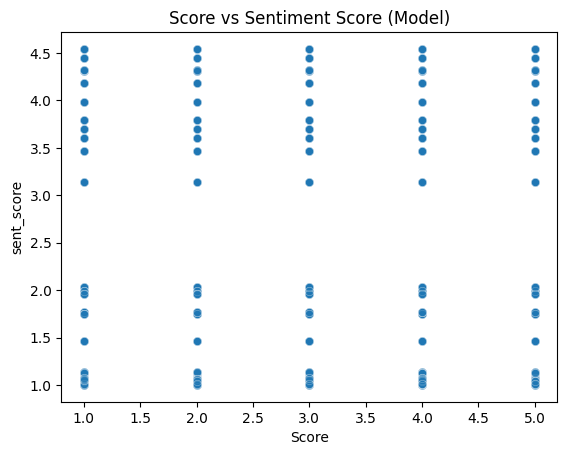

In [18]:
sns.scatterplot(
    data=df,
    x="Score",
    y="sent_score",
    alpha=0.3
)
plt.title("Score vs Sentiment Score (Model)")
plt.show()


📌 **Score – Sentiment Tutarsızlık Analizi**

Score ile model tarafından tahmin edilen sentiment_score genel olarak pozitif bir korelasyon göstermektedir.
Bununla birlikte veri setinde dikkat çekecek düzeyde tutarsız puan–yorum eşleşmeleri de bulunmaktadır.

Bu tutarsızlıkların temel nedenleri şunlar olabilir:

Kullanıcı puanlama alışkanlıklarının tutarsız olması
(Örneğin; pozitif metne düşük puan verme, negatif metne yüksek puan verme)

Modelin belirli metin tiplerinde zorlanması
(Çok kısa yorumlar, bağlamdan kopuk cümleler vb.)

Puanlamanın metinden bağımsız verilmesi
(Örneğin; kredi reddi, araç bulunamaması gibi süreçsel sebepler)

Mismatch analizi ile bu tutarsız yorumları analiz edebiliriz.

## Mismatch

In [19]:
condition_pos_text_low_score = (
    (df["sent_score"] >= 3.4) &   # model diyor ki: pozitif metin
    (df["Score"] <= 2)                       # kullanıcı düşük puan vermiş
)
df_pos_low = df[condition_pos_text_low_score]
print("📌 Pozitif metin + Düşük puan vaka sayısı:", len(df_pos_low))
df_pos_low


📌 Pozitif metin + Düşük puan vaka sayısı: 6386


,ID,Score,Title,Feedback,Timestamp,Cleaned_Feedback,sent_pos,sent_neg,sent_score,sent_label
5,6,2.0,Krediye Ulaşma Yorumu,Krediye ulaşmak çok kolay oldu.,2025-10-22 13:07:09,krediye ulaşmak kolay oldu,0.651511,0.348489,3.606044,positive
9,10,2.0,Destek Ekibi Yorumu,Destek ekibi süreci hızlandırdı.,2025-10-22 13:07:09,destek ekibi süreci hızlandırdı,0.796705,0.203295,4.186821,positive
11,12,2.0,Krediye Ulaşma Yorumu,Krediye ulaşmak beklediğimden kolaydı.,2025-10-22 13:07:09,krediye ulaşmak beklediğimden kolaydı,0.675248,0.324752,3.700991,positive
41,42,1.0,Kredi Yorumu,Kredi başvurum hızlıca onaylandı.,2025-10-22 13:07:09,kredi başvurum hızlıca onaylandı,0.830270,0.169730,4.321080,positive
49,50,2.0,Krediye Ulaşma Yorumu,Krediye ulaşmak için online başvuru yeterliydi.,2025-10-22 13:07:09,krediye ulaşmak online başvuru yeterliydi,0.861159,0.138841,4.444634,positive
...,...,...,...,...,...,...,...,...,...,...
49946,49947,1.0,Krediye Ulaşma Yorumu,Krediye ulaşmak beklediğimden kolaydı.,2025-10-22 13:07:09,krediye ulaşmak beklediğimden kolaydı,0.675248,0.324752,3.700991,positive
49982,49983,2.0,Destek Ekibi Yorumu,Destek ekibi tüm sorularımı yanıtladı.,2025-10-22 13:07:09,destek ekibi sorularımı yanıtladı,0.699275,0.300725,3.797101,positive
49986,49987,1.0,Araç Bulunurluğu Yorumu,Aradığım aracı hemen bulabildim.,2025-10-22 13:07:09,aradığım aracı hemen bulabildim,0.885354,0.114646,4.541418,positive
49993,49994,2.0,Destek Ekibi Yorumu,Destek ekibi profesyoneldi.,2025-10-22 13:07:09,destek ekibi profesyoneldi,0.616486,0.383514,3.465943,neutral


In [20]:
condition_neg_text_high_score = (
    (df["sent_score"] <= 2.5) &   # model diyor ki: negatif metin
    (df["Score"] >= 4)                       # kullanıcı yüksek puan vermiş
)
df_neg_high = df[condition_neg_text_high_score]
print("📌 Negatif metin + Yüksek puan vaka sayısı:", len(df_neg_high))
df_neg_high


📌 Negatif metin + Yüksek puan vaka sayısı: 13108


,ID,Score,Title,Feedback,Timestamp,Cleaned_Feedback,sent_pos,sent_neg,sent_score,sent_label
1,2,4.0,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09,destek ekibi ulaşılması zordu,0.035218,0.964782,1.140872,negative
4,5,5.0,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09,destek ekibi ulaşılması zordu,0.035218,0.964782,1.140872,negative
13,14,5.0,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09,destek ekibi ulaşılması zordu,0.035218,0.964782,1.140872,negative
14,15,4.0,Kredi Yorumu,Kredi faiz oranları makul seviyedeydi.,2025-10-22 13:07:09,kredi faiz oranları makul seviyedeydi,0.248228,0.751772,1.992913,negative
16,17,5.0,Kredi Yorumu,Kredi şartları açık ve anlaşılırdı.,2025-10-22 13:07:09,kredi şartları açık anlaşılırdı,0.240691,0.759309,1.962766,negative
...,...,...,...,...,...,...,...,...,...,...
49983,49984,4.0,Kredi Yorumu,Kredi şartları açık ve anlaşılırdı.,2025-10-22 13:07:09,kredi şartları açık anlaşılırdı,0.240691,0.759309,1.962766,negative
49984,49985,5.0,Kredi Yorumu,Kredi süreci çok uzadı.,2025-10-22 13:07:09,kredi süreci uzadı,0.003271,0.996729,1.013083,negative
49988,49989,5.0,Araç Bulunurluğu Yorumu,Araç bulmakta hiç zorlanmadım.,2025-10-22 13:07:09,araç bulmakta zorlanmadım,0.031019,0.968981,1.124078,negative
49990,49991,4.0,Destek Ekibi Yorumu,Destek ekibi sorunumu çözdü.,2025-10-22 13:07:09,destek ekibi sorunumu çözdü,0.115719,0.884281,1.462875,negative


In [21]:

df["Mismatch"] = df.apply(mismatch_type, axis=1)
df["Mismatch"].value_counts()

Mismatch
Consistent                  31130
Negative_Text_High_Score    13108
Positive_Text_Low_Score      5762
Name: count, dtype: int64

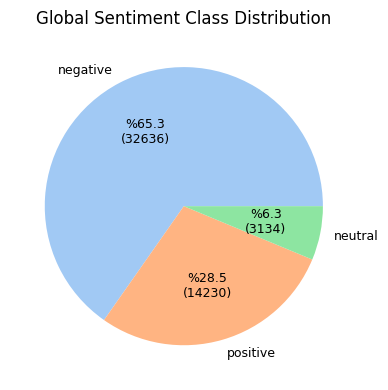

In [22]:
plot_pie_with_counts(df, "sent_label", "Global Sentiment Class Distribution")


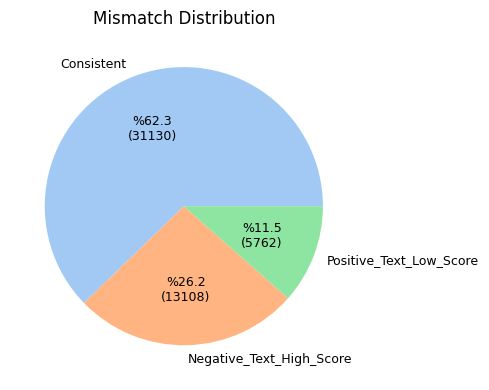

In [23]:
plot_pie_with_counts(df, "Mismatch", "Mismatch Distribution")


### 📌 Mismatch Analizi

**En büyük grup: Consistent (31.130 adet)***
Verilerin büyük çoğunluğunda kullanıcıların verdiği puan ile yazdıkları metnin duygu tonu **uyumlu** görünmektedir.
Bu durum, sentiment modelinin genel eğilimleri başarılı şekilde yakaladığını ve puanlama davranışının çoğunlukla metne paralel olduğunu göstermektedir.

---


Oldukça dikkat çekici bir şekilde, **13 binden fazla** kayıtta kullanıcı yorumunun tonu negatif olmasına rağmen verilen puan yüksektir.

Bu durum birkaç olasılığı işaret etmektedir:
- Kullanıcılar memnuniyetsiz ifadeler yazarken bile alışkanlıkla “iyi” puan verebiliyor.
- Metin “eleştirel ama yapıcı” olabilir; model tonu negatif sınıflandırmıştır.
- Bazı yorumlar karma duygu içerebilir (örn. *“süreç yavaştı ama genel olarak memnunum”*).
- Puanlama davranışı yorumdan bağımsız tetikleniyor olabilir.

---

**Pozitif metin + düşük puan: 5.762 adet**
Bu kayıtlar daha az sayıda olsa da yine önemli bir grubu temsil etmektedir.

Olası nedenler:
- Metin olumlu olsa da kullanıcı düşük puan vermiş olabilir.
- Yorum süreç hakkında olumlu olsa bile puanı etkileyen başka bir olumsuz deneyim yaşanmış olabilir.
- Model çok kısa veya nötr metinleri “pozitif” olarak yorumlamış olabilir.
- Kullanıcı tek bir olumsuz olay nedeniyle puanı düşürmüş olabilir.


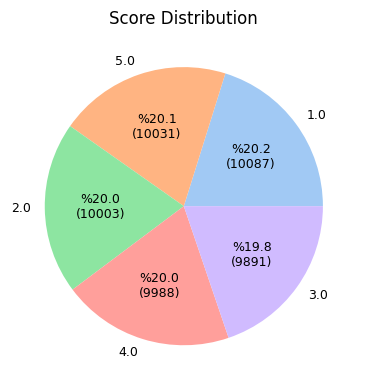

In [24]:
plot_pie_with_counts(df, "Score", "Score Distribution")

### 📌 Kullanıcı Puanları

**Dengeli Puanlama Göze Çarpıyor**
Puan dağılımı her score için neredeyse eşit. Kullanıcı memnüniyeti için genel kanıya varmak verilen score ile mümkün gözükmüyor.


In [25]:
topic_df = topic_stats(df)
topic_df


,Title,n_comments,mean_sentiment,pos_ratio,neg_ratio
0,Araç Bulunurluğu Yorumu,12540,1.864853,0.255502,0.744498
1,Destek Ekibi Yorumu,12428,2.345147,0.255713,0.616270
2,Kredi Yorumu,12441,2.363229,0.253195,0.622780
3,Krediye Ulaşma Yorumu,12591,2.229416,0.373124,0.626876




**Yorum Başlıkları**
- Yorumlar alt başlıklara dengeli dağılmış. Ufak br fark ile en çok yorum **Araç Bulunurluğu** konusunda. Verilen puanlara göre en memnun olunan konu **Destek Ekibi**. 


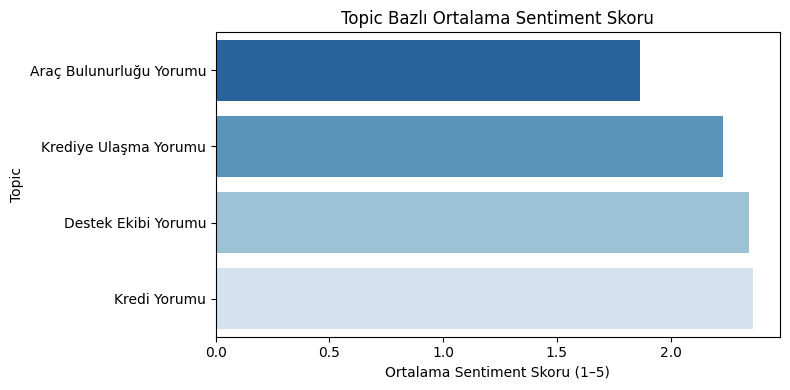

In [26]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=topic_df.sort_values("mean_sentiment"),   # ✔️ DataFrame direkt veriliyor
    x="mean_sentiment",
    y="Title",
    hue="Title",            # FutureWarning çözümü
    dodge=False,
    legend=False,           # Legend kapatılıyor
    palette="Blues_r"       # Güzel soft mavi tonları
)

plt.title("Topic Bazlı Ortalama Sentiment Skoru")
plt.xlabel("Ortalama Sentiment Skoru (1–5)")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()



- Sentiment skore ile değerlendirildiğinde en çok memnuniyet sağlayan konu **Krediler** konusunda.

## Non-Rag

In [27]:
df.head()

,ID,Score,Title,Feedback,Timestamp,Cleaned_Feedback,sent_pos,sent_neg,sent_score,sent_label,Mismatch
0,1,3.0,Araç Bulunurluğu Yorumu,Araç stokları çok sınırlıydı.,2025-10-22 13:07:09,araç stokları sınırlıydı,0.016086,0.983914,1.064345,negative,Consistent
1,2,4.0,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09,destek ekibi ulaşılması zordu,0.035218,0.964782,1.140872,negative,Negative_Text_High_Score
2,3,3.0,Destek Ekibi Yorumu,Destek ekibi beklediğimden iyiydi.,2025-10-22 13:07:09,destek ekibi beklediğimden iyiydi,0.193266,0.806734,1.773062,negative,Consistent
3,4,3.0,Araç Bulunurluğu Yorumu,Araç bulunurluğu beklediğimden kötüydü.,2025-10-22 13:07:09,araç bulunurluğu beklediğimden kötüydü,0.000673,0.999327,1.002690,negative,Consistent
4,5,5.0,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09,destek ekibi ulaşılması zordu,0.035218,0.964782,1.140872,negative,Negative_Text_High_Score


In [28]:
df["Feedback_norm"] = df["Feedback"].apply(normalize_for_embedding)

In [29]:
emb_matrix, unique_texts, emb_map, embed_model = generate_embeddings_for_unique_texts(
    df,
    text_column="Feedback_norm",
    normalize_fn=normalize_for_embedding
)



[INFO] Embedding modeli yükleniyor: distiluse-base-multilingual-cased-v2
[INFO] Unique (normalized) text sayısı: 32
[INFO] Embedding oluşturuluyor...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Embedding işlemi tamamlandı.
[INFO] emb_matrix shape: (32, 512), dtype: float16


In [30]:
most_similar_feedback(
    "araç",
    top_k=10,
    embed_model=embed_model,
    emb_matrix=emb_matrix,
    unique_texts=unique_texts,
    normalize_fn=normalize_for_embedding
)

,Feedback_norm,similarity
0,Araç bulunurluğu iyiydi.,0.234777
1,Araç seçenekleri fazlaydı.,0.156821
2,Araç teslimatı hızlı gerçekleşti.,0.125077
3,Araç bulmakta hiç zorlanmadım.,0.118250
4,Araç bulunurluğu beklediğimden kötüydü.,0.114642
5,Destek ekibi profesyoneldi.,0.114535
6,Araç stokları çok sınırlıydı.,0.106928
7,Aradığım aracı hemen bulabildim.,0.103072
8,Destek ekibi sorunumu çözdü.,0.033703
9,Destek ekibi çok ilgiliydi.,0.016558


## Rag

In [31]:
df.head()

,ID,Score,Title,Feedback,Timestamp,Cleaned_Feedback,sent_pos,sent_neg,sent_score,sent_label,Mismatch,Feedback_norm
0,1,3.0,Araç Bulunurluğu Yorumu,Araç stokları çok sınırlıydı.,2025-10-22 13:07:09,araç stokları sınırlıydı,0.016086,0.983914,1.064345,negative,Consistent,Araç stokları çok sınırlıydı.
1,2,4.0,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09,destek ekibi ulaşılması zordu,0.035218,0.964782,1.140872,negative,Negative_Text_High_Score,Destek ekibi ulaşılması zordu.
2,3,3.0,Destek Ekibi Yorumu,Destek ekibi beklediğimden iyiydi.,2025-10-22 13:07:09,destek ekibi beklediğimden iyiydi,0.193266,0.806734,1.773062,negative,Consistent,Destek ekibi beklediğimden iyiydi.
3,4,3.0,Araç Bulunurluğu Yorumu,Araç bulunurluğu beklediğimden kötüydü.,2025-10-22 13:07:09,araç bulunurluğu beklediğimden kötüydü,0.000673,0.999327,1.002690,negative,Consistent,Araç bulunurluğu beklediğimden kötüydü.
4,5,5.0,Destek Ekibi Yorumu,Destek ekibi ulaşılması zordu.,2025-10-22 13:07:09,destek ekibi ulaşılması zordu,0.035218,0.964782,1.140872,negative,Negative_Text_High_Score,Destek ekibi ulaşılması zordu.


In [32]:
sub_df, summary, retrieval_time, stats_time, total_time = rag_query(
    df=df,
    query="araç",
    embed_model=embed_model,
    emb_matrix=emb_matrix,
    unique_texts=unique_texts,
        top_k=5
)

In [33]:
summary

{'query': 'araç',
 'n_comments': 7809,
 'mean_sentiment_model': None,
 'std_sentiment_model': None,
 'mean_user_score': 3.014726597515687,
 'std_user_score': 1.4070094234165058,
 'retrieval_time_s': 0.08474190000015369,
 'stats_time_s': 0.0017762999996193685,
 'total_time_s': 0.08651819999977306}

In [34]:
sub_df

,ID,Score,Title,Feedback,Timestamp,Cleaned_Feedback,sent_pos,sent_neg,sent_score,sent_label,Mismatch,Feedback_norm,similarity
3,4,3.0,Araç Bulunurluğu Yorumu,Araç bulunurluğu beklediğimden kötüydü.,2025-10-22 13:07:09,araç bulunurluğu beklediğimden kötüydü,0.000673,0.999327,1.002690,negative,Consistent,Araç bulunurluğu beklediğimden kötüydü.,0.114642
18,19,2.0,Araç Bulunurluğu Yorumu,Araç bulmakta hiç zorlanmadım.,2025-10-22 13:07:09,araç bulmakta zorlanmadım,0.031019,0.968981,1.124078,negative,Consistent,Araç bulmakta hiç zorlanmadım.,0.118250
27,28,5.0,Araç Bulunurluğu Yorumu,Araç bulunurluğu beklediğimden kötüydü.,2025-10-22 13:07:09,araç bulunurluğu beklediğimden kötüydü,0.000673,0.999327,1.002690,negative,Negative_Text_High_Score,Araç bulunurluğu beklediğimden kötüydü.,0.114642
36,37,2.0,Araç Bulunurluğu Yorumu,Araç bulunurluğu beklediğimden kötüydü.,2025-10-22 13:07:09,araç bulunurluğu beklediğimden kötüydü,0.000673,0.999327,1.002690,negative,Consistent,Araç bulunurluğu beklediğimden kötüydü.,0.114642
57,58,1.0,Araç Bulunurluğu Yorumu,Araç teslimatı hızlı gerçekleşti.,2025-10-22 13:07:09,araç teslimatı hızlı gerçekleşti,0.744847,0.255153,3.979386,positive,Positive_Text_Low_Score,Araç teslimatı hızlı gerçekleşti.,0.125077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49981,49982,3.0,Araç Bulunurluğu Yorumu,Araç teslimatı hızlı gerçekleşti.,2025-10-22 13:07:09,araç teslimatı hızlı gerçekleşti,0.744847,0.255153,3.979386,positive,Consistent,Araç teslimatı hızlı gerçekleşti.,0.125077
49985,49986,3.0,Araç Bulunurluğu Yorumu,Araç teslimatı hızlı gerçekleşti.,2025-10-22 13:07:09,araç teslimatı hızlı gerçekleşti,0.744847,0.255153,3.979386,positive,Consistent,Araç teslimatı hızlı gerçekleşti.,0.125077
49988,49989,5.0,Araç Bulunurluğu Yorumu,Araç bulmakta hiç zorlanmadım.,2025-10-22 13:07:09,araç bulmakta zorlanmadım,0.031019,0.968981,1.124078,negative,Negative_Text_High_Score,Araç bulmakta hiç zorlanmadım.,0.118250
49989,49990,5.0,Araç Bulunurluğu Yorumu,Araç teslimatı hızlı gerçekleşti.,2025-10-22 13:07:09,araç teslimatı hızlı gerçekleşti,0.744847,0.255153,3.979386,positive,Consistent,Araç teslimatı hızlı gerçekleşti.,0.125077


In [35]:
sub_df[["Feedback", "Score", "sent_score", "sent_label","similarity"]].head(10)


,Feedback,Score,sent_score,sent_label,similarity
3,Araç bulunurluğu beklediğimden kötüydü.,3.0,1.002690,negative,0.114642
18,Araç bulmakta hiç zorlanmadım.,2.0,1.124078,negative,0.118250
27,Araç bulunurluğu beklediğimden kötüydü.,5.0,1.002690,negative,0.114642
36,Araç bulunurluğu beklediğimden kötüydü.,2.0,1.002690,negative,0.114642
57,Araç teslimatı hızlı gerçekleşti.,1.0,3.979386,positive,0.125077
62,Araç teslimatı hızlı gerçekleşti.,3.0,3.979386,positive,0.125077
73,Araç bulunurluğu beklediğimden kötüydü.,1.0,1.002690,negative,0.114642
74,Araç seçenekleri fazlaydı.,1.0,1.043779,negative,0.156821
79,Araç bulmakta hiç zorlanmadım.,1.0,1.124078,negative,0.118250
87,Araç bulunurluğu iyiydi.,1.0,1.012741,negative,0.234777


## Rag vs Non-Rag Hız Karşılaştırması

In [36]:
queries = [
    "araç bulamadım çok zorlandım",
    "kredi başvurusu süreci",
    "destek ekibi çok yavaştı",
]

results = []
for q in queries:
    nonrag_t, rag_t = compare_rag_vs_nonrag(
        df=df,
        query=q,
        embed_model=embed_model,
        emb_matrix=emb_matrix,
        unique_texts=unique_texts,
        normalize_fn=normalize_for_embedding,
        top_k=20,
    )
    results.append((q, nonrag_t, rag_t))

for q, nonrag_t, rag_t in results:
    print(f"Query: {q}")
    print(f"  Non-RAG latency: {nonrag_t*1000:.1f} ms")
    print(f"  RAG latency   : {rag_t*1000:.1f} ms")
    print()


Query: araç bulamadım çok zorlandım
  Non-RAG latency: 105.0 ms
  RAG latency   : 115.8 ms

Query: kredi başvurusu süreci
  Non-RAG latency: 59.0 ms
  RAG latency   : 125.2 ms

Query: destek ekibi çok yavaştı
  Non-RAG latency: 78.2 ms
  RAG latency   : 132.2 ms



Bu sonuçlara göre, yalnızca benzer yorumları getirme aşamasında bile **RAG pipeline’ı Non-RAG’e kıyasla daha uzun sürmektedir**.

---


Her iki yaklaşım da “benzer yorumları bulmak” için embedding tabanlı cosine similarity kullanıyor gibi görünse de, farklılıklar var:

---

**Non-RAG = tek adımlı saf semantic search**

Non-RAG (most_similar_feedback) işlemleri:

1. Sorgu embedding'ini üretir  
2. `emb_matrix` ile cosine similarity hesaplar  
3. İlk `top_k` sonucu döndürür  


Tamamen **stateless**, ek filtreleme ve ek veri işleme yok. Bu nedenle daha hızlı.

---

**RAG = retrieval + yorum bazlı alt küme üretimi**

RAG tarafı, benim implementasyonumda retrieval sırasında Non-RAG’e göre birkaç ek iş yapar:

1. Sorgu metni normalize edilir (`normalize_for_embedding`)  
2. `embed_model.encode` ile sorgu embedding’i üretilir  
3. `_retrieve_topk_indices_and_sims` ile:
   - `emb_matrix` üzerinde cosine similarity hesaplanır  
   - `np.argpartition` ve `argsort` kullanılarak en benzer `top_k` index seçilir  
   - Bu index’lere karşılık gelen `retrieved_texts` ve `sims_top` elde edilir  
4. Daha sonra ana `df` üzerinden:
   - `df[feedback_col].isin(retrieved_texts)` ile ilgili satırlar filtrelenir ve `sub_df` oluşturulur  
   - `retrieved_texts` ve `sims_top` bir `dict` haline getirilir (`sim_map`)  
   - `sub_df["similarity"] = sub_df[feedback_col].map(sim_map)` ile her satıra benzerlik skoru eklenir  

Bu nedenle, embedding ve cosine similarity kısmı aynı olmasına rağmen,  
**RAG tarafında retrieval + altküme oluşturma süresi Non-RAG’e kıyasla doğal olarak daha uzundur.**






